In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# netcdf with Nans create a lot of misc warnings when you decode them
import warnings
warnings.filterwarnings('ignore')

In [3]:
def list_experiments(path, variableName="cVeg"):
    exps = set()
    for filename in os.listdir(path):
        if filename.startswith(variableName):
            #print(filename)
            exps.add(filename.split("_")[2])
    return exps


def load(path, variableName="cVeg", experiment="CanESM5"):
    experimentfiles = []
    for filename in os.listdir(path):
        if filename.startswith(variableName + "_") and filename.split("_")[2].lower() == experiment.lower():
            experimentfiles.append(path + filename)
    
    experimentfiles.sort()
    nplist = []
    
    for filename in experimentfiles:
        arr = xr.open_dataset(filename)[variableName].to_numpy()
        nplist.append(arr)

    final = np.concatenate(nplist)    
    return final    

In [4]:
start_x = 12*(0) # 1850
end_x = 12*(25) # 1875
start_y = 12*(75) # 1925
end_y = 12*(100) # 1950

def avg20(ds):
    return np.mean(ds, axis=0) # axis of mean = time

def std20(ds):
    return np.std(ds, axis=0)

In [5]:
from sklearn.linear_model import LinearRegression

In [6]:
def plot_and_test(input, output, mask,color=None,ax=plt):
    output = output[mask].flatten()
    input = input[mask].flatten()
    
    ax.scatter(input, output, alpha=0.2, color=color)

def globe(imagedata, ax=None, **kwargs):
    imageshape = imagedata.shape
    half1 = imagedata[:,imageshape[1]//2:]
    half2 = imagedata[:,:imageshape[1]//2]

    if ax != None:
        #imagedata = imagedata[:,:imageshape[0]//2]
        #return ax.imshow(imagedata, **kwargs)
        return ax.imshow(np.concatenate([half1, half2],axis=1), **kwargs)
    else:
        plt.imshow(np.concatenate([half1, half2],axis=1), **kwargs)

# Here Be Dragons...
def fit_and_test(inputs, output, masks, test_inputs, test_output, title=""):
    modelshape = inputs[0].shape

    predicted_present = np.full(modelshape, np.nan)
    predicted_future = np.full(modelshape, np.nan)

    cmip_present = np.full(modelshape, np.nan)
    cmip_future = np.full(modelshape, np.nan)

    labels = ["Tropics", "Extratropics"]
    maskidx = 0
    fig = plt.figure()

    ax = fig.add_subplot(projection='3d')
    ax.set_xlabel('Temperature')
    ax.set_ylabel('Precipitation')
    ax.set_zlabel('MSE')

    for mask in masks:
        # Prepare and mask inputs/outputs for linreg
        model_inputs = inputs[:,mask]#.flatten()
        model_test_inputs = test_inputs[:,mask]#.flatten()
        
        model_inputs = np.array(model_inputs).transpose()
        model_test_inputs = np.array(model_test_inputs).transpose()
        
        model_output = output[mask].flatten()
        model_test_output = test_output[mask].flatten()
    
        # Fit and score model
        model = LinearRegression()
        model.fit(model_inputs, model_output)
    
        R2_present = model.score(model_inputs, model_output)
        R2_future = model.score(model_test_inputs, model_test_output)

        linear_outputs = model.predict(model_inputs) 
        linear_test_outputs = model.predict(model_test_inputs)

        mse = (model_output - linear_outputs)**2
        mse_test = (model_test_output - linear_test_outputs)**2

        ax.scatter(model_inputs[:,0],model_inputs[:,1],mse)
        #ax.scatter(model_inputs[0,:],model_inputs[1,:],mse_test)
        
        
        #print(title, "*", model.coef_, "+", model.intercept_)
        
        #print(title, labels[maskidx], "Adjusted Coefficients", model.coef_[0] * np.std(inputs[0,mask]), model.coef_[1] * np.std(inputs[1,mask]), model.coef_[2] * np.std(inputs[2,mask]), "+",model.intercept_)
        #print(title, labels[maskidx], "Adjusted Intercept", model.intercept_ + (model.coef_[0] * np.mean(inputs[0,mask])) + (model.coef_[1] * np.mean(inputs[1,mask])) + (model.coef_[2] * np.mean(inputs[2,mask])))
        
        #print(np.std(inputs[0,mask]), np.std(inputs[1,mask]), np.std(inputs[2,mask]))
        
        #print(title, "R^2 Present", R2_present)
        print(title, "R^2 Future", R2_future) 
        
        predicted_present[mask] = linear_outputs
        predicted_future[mask] = linear_test_outputs
    
        cmip_present[mask] = model_output  
        cmip_future[mask] = model_test_output
        maskidx += 1

    #plt.savefig('figure_'+title+"subplot"+'.png')

    # Setup plots
    fig, axs = plt.subplots(3, 3, figsize=(36, 18)) #+ 4 * len(inputs)))
    plt.subplots_adjust(wspace=0.1, hspace=0)
    plt.tight_layout()
    fig.suptitle(title)
    axs[0][0].set_title("Historical")
    axs[0][1].set_title("Future")
    axs[0][2].set_title("Difference")
    
    axs[0][0].set_ylabel("CMIP")
    globe(cmip_present[::-1], axs[0][0], vmin=0, vmax=16, interpolation='none', extent=[-180,180,-90,90])
    #pcm0 = axs[0][1].imshow(cmip_future[::-1], vmin=0, vmax=16, interpolation='none', extent=[0,360,-90,90])
    pcm0 = globe(cmip_future[::-1], axs[0][1], vmin=0, vmax=16, interpolation='none', extent=[-180,180,-90,90])
    
    axs[1][0].set_ylabel("Predicted")
    globe(predicted_present[::-1], axs[1][0],  vmin=0, vmax=16, interpolation='none', extent=[-180,180,-90,90])
    pcm1 = globe(predicted_future[::-1],axs[1][1],  vmin=0, vmax=16, interpolation='none', extent=[-180,180,-90,90])
    cbar1 = fig.colorbar(pcm1, ax=[axs[0][0], axs[0][1], axs[1][0], axs[1][1]], shrink=0.5, location='left')
    cbar1.ax.set_ylabel("cVeg (kg/m^2)")
    
    #axs[2][0].set_ylabel("Residuals")
    #axs[2][0].imshow(predicted_present[::-1] - cmip_present[::-1], vmin=-5, vmax=5, cmap="coolwarm", interpolation='none', extent=[0,360,-90,90])
    #pcm2 = axs[2][1].imshow(predicted_future[::-1] - cmip_future[::-1], vmin=-5, vmax=5, cmap="coolwarm", interpolation='none', extent=[0,360,-90,90])
    #fig.colorbar(pcm2, ax=[axs[2][0],axs[2][1]], shrink=0.5)

    pcmr1 = globe(cmip_future[::-1] - cmip_present[::-1], axs[0][2], vmin=-3, vmax=3, cmap="coolwarm", interpolation='none', extent=[-180,180,-90,90])
    pcmr2 = globe(predicted_future[::-1] - predicted_present[::-1], axs[1][2], vmin=-3, vmax=3, cmap="coolwarm", interpolation='none', extent=[-180,180,-90,90])
    cbar2 = fig.colorbar(pcmr1, ax=[axs[0,2],axs[1,2]], shrink=0.5)
    cbar2.ax.set_ylabel("cVeg (kg/m^2)")

    globalmask = masks[0] | masks[1]

    labels = ["Temperature" , "Precipitation", "VPD"]
    bounds = [10,2.5*1e-5,1]
    
    for i in range(2):
        inputs[i][~globalmask] = np.nan
        test_inputs[i][~globalmask] = np.nan
        
        axs[2][i].set_title(labels[i] + " change 50yrs")
        pcminp = globe(test_inputs[i][::-1] - inputs[i][::-1], axs[2][i], cmap="Spectral", vmin=-bounds[i],vmax=bounds[i], extent=[-180,180,-90,90])
        fig.colorbar(pcminp, ax=axs[2][i], shrink=0.5)
    
    #plt.savefig('figure_'+title+'.png')
    
    
    return model

In [7]:
# Choose r to make sphere surface area 1 for easy multiplication later
# r = sqrt(1/4pi)
r = np.sqrt(1/(4*np.pi))

# Gets height of section of sphere given two angles
def getH(angles):
    angle_min = np.min(angles)
    angle_max = np.max(angles)
    
    # Hypotenuse = r
    # Hypotenuse * sin(Theta) = Opposite
    h_min = r * np.sin(angle_min)
    h_max = r * np.sin(angle_max)
    return h_max - h_min

# https://en.wikipedia.org/wiki/Spherical_segment
def getArea(horizontal_angles,vertical_angles,in_degrees=True):
    if in_degrees: # We need radians
        horizontal_angles *= (np.pi / 180)
        vertical_angles *= (np.pi / 180)

    left_bound = np.min(horizontal_angles)
    right_bound = np.max(horizontal_angles)
    arc_horz = right_bound - left_bound

    # 2 * pi * r * h * arc2
    return 2 * np.pi * r * getH(vertical_angles) * (arc_horz/(2*np.pi))

# should theoretically equal 1
print(getArea(np.array([-180,180], dtype=np.float64),np.array([90,-90], dtype=np.float64)))

def cuts(amount_vertical,amount_horizontal,vstart=90):
    space = np.linspace(-vstart,vstart,amount_vertical+1)
    width = 360/amount_horizontal
    y = []
    # We only care about vertical dimension
    for i in range(amount_vertical):
        y.append(getArea(np.array([0,width], dtype=np.float64), np.array([space[i],space[i+1]], dtype=np.float64)))
    x = np.array([y] * amount_horizontal)
    return x.transpose()

#cuts(10,5) # This may be in the wrong orientation but we can always transpose    

0.9999999999999999


<Figure size 800x400 with 0 Axes>

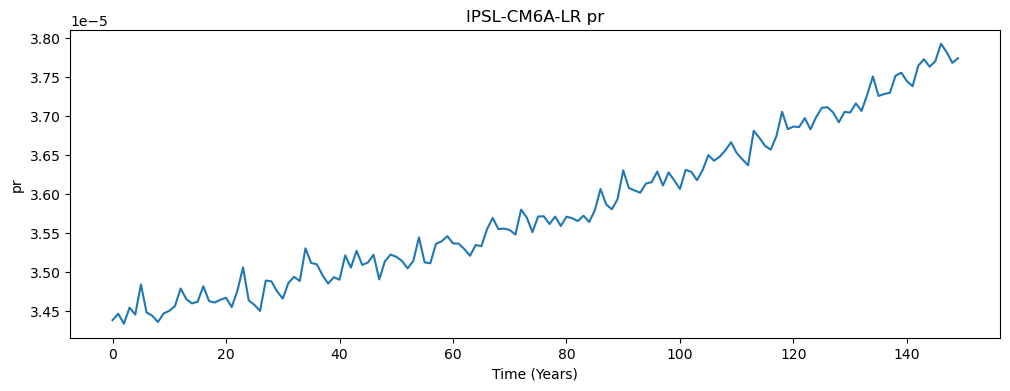

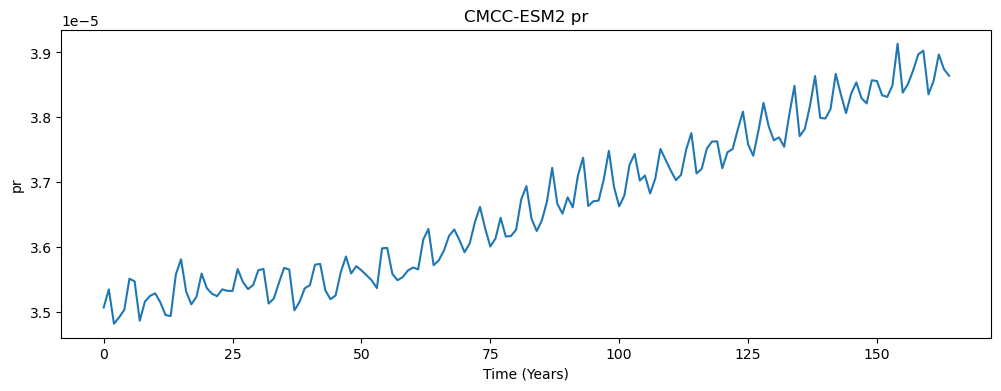

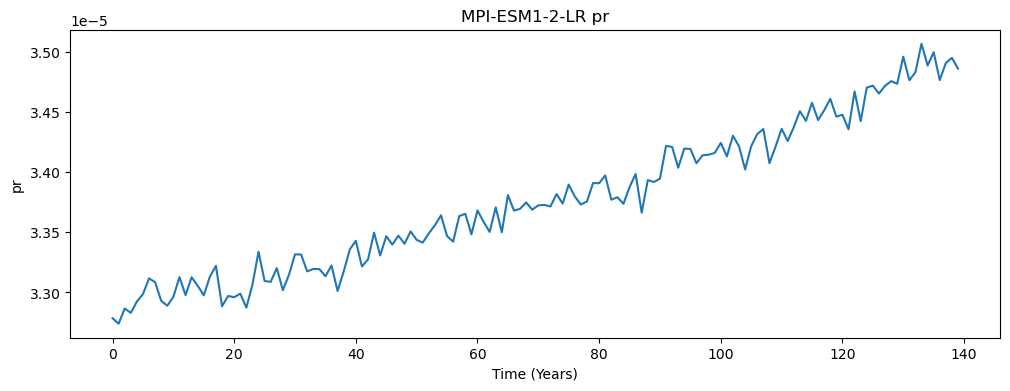

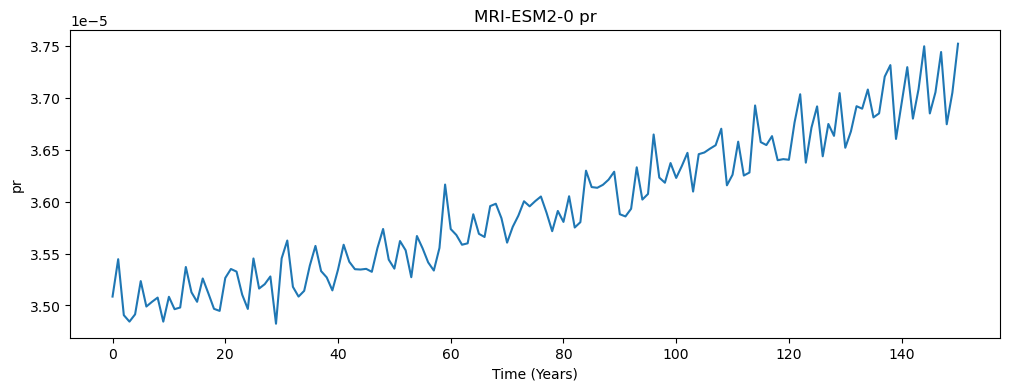

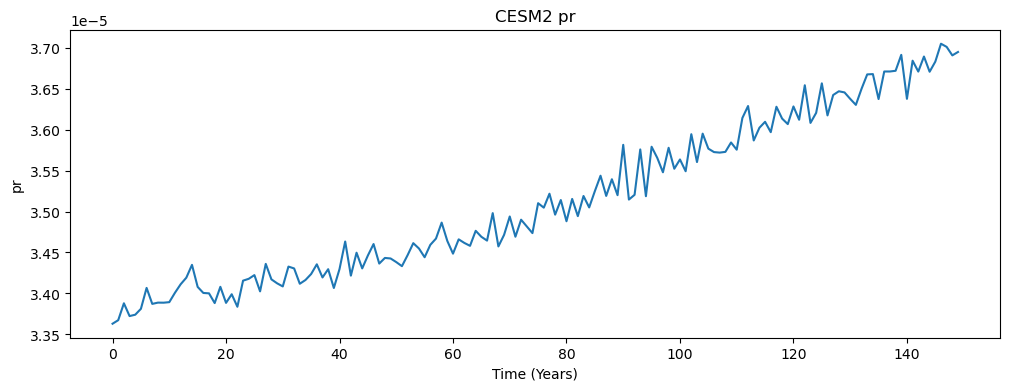

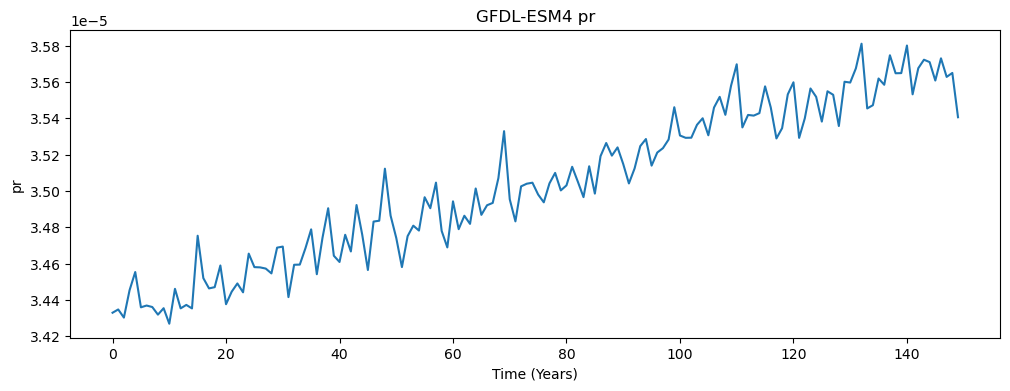

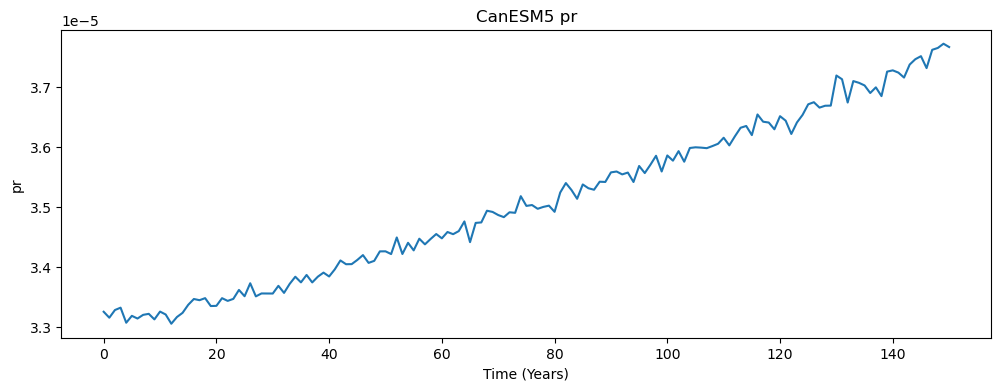

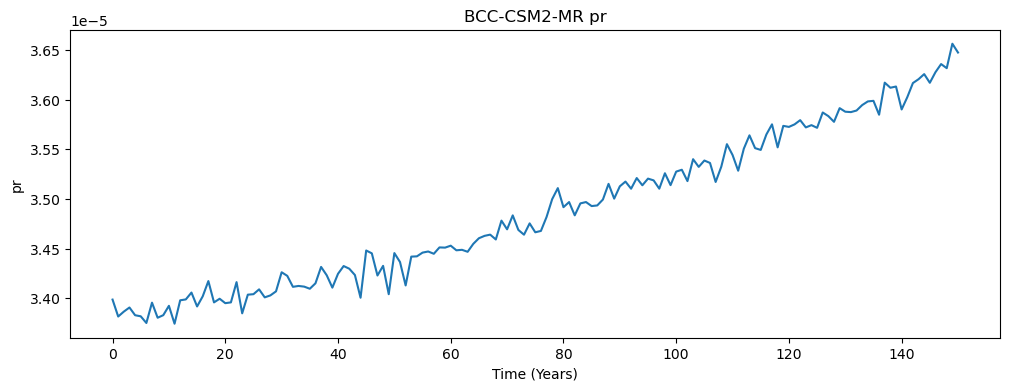

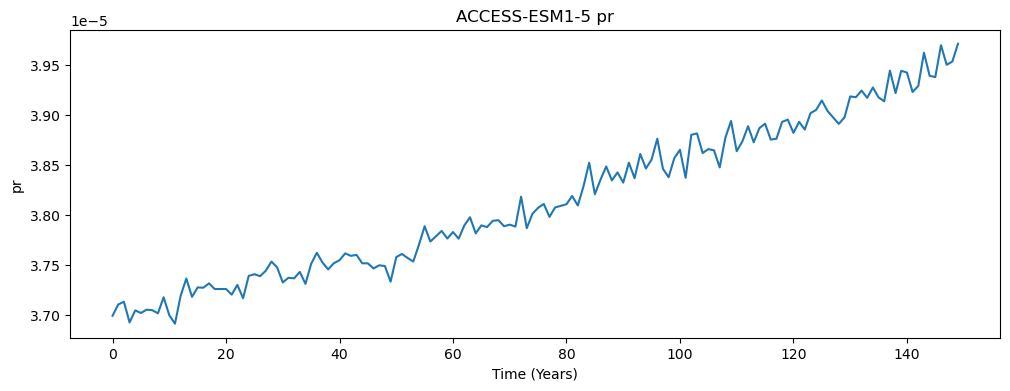

In [8]:
if True:
    def timeseries(values, name="", fig=plt.figure(figsize=(8,4))):
        weights = cuts(values.shape[1],values.shape[2])
        
        values = np.nan_to_num(values)
        monthly = np.sum(values * weights, axis=(1,2))
        yearly = np.mean(monthly.reshape(-1, 12), axis=1)
        
        plt.plot(yearly)
        plt.title(name)
        plt.xlabel("Time (Years)")


    timeseries_var = "pr"
    
    for expname in list_experiments("./1pctCO2-rad/",timeseries_var):
        fig = plt.figure(figsize=(12,4))
        timeseries(load("./1pctCO2-rad/",timeseries_var, expname), expname + " " + timeseries_var, fig)
        #timeseries(load("./piSST-4xCO2-rad/",timeseries_var, expname), expname + " " + timeseries_var, fig)
        #plt.legend(["piSST-4xCO2", "piSST-4xCO2-rad"])
        plt.ylabel(timeseries_var)

In [9]:
def vpd(ts, hurs):
    ts_c = ts - 273.15
    vpsat = 6.1094 * np.exp(17.625 * ts_c / (ts_c + 243.04)) # in hPa, from claus-clap wikipedia page
    #plt.imshow(vpsat)
    #plt.colorbar()

    vpd = (vpsat/10) * ((100-hurs)/100) # from vpd wikipedia page, unit shouldnt matter because scaler * percent?
    return vpd

In [10]:
if False:
    i = 0
    exptype = "./1pctCO2-rad/"
    for expname in list_experiments(exptype, "hurs"):
        cveg_data = load(exptype, "cVeg", expname)
        pr_data = load(exptype, "pr", expname)
        ts_data = load(exptype, "ts", expname)
        hurs_data = load(exptype, "hurs", expname)
        sn_data = load(exptype, "prsn", expname)
        
        x_cveg = avg20(cveg_data[start_x:end_x,:,:])
        x_ts = avg20(ts_data[start_x:end_x,:,:])
        x_pr = avg20(pr_data[start_x:end_x,:,:])
        x_hurs = avg20(hurs_data[start_x:end_x,:,:])
        x_sn = avg20(sn_data[start_x:end_x,:,:])
        #x_gpp = avg20(gpp_data[start_x:end_x,:,:])
        y_ts = avg20(ts_data[start_y:end_y,:,:])
        y_pr = avg20(pr_data[start_y:end_y,:,:])
        y_hurs = avg20(hurs_data[start_y:end_y,:,:])
        #y_gpp = avg20(gpp_data[start_y:end_y,:,:])
        y_cveg = avg20(cveg_data[start_y:end_y,:,:])
        y_sn = avg20(sn_data[start_y:end_y,:,:])
    
        x_std = std20(pr_data[start_x:end_x,:,:])
        y_std = std20(pr_data[start_y:end_y,:,:])
    
        x_vpd = vpd(x_ts, x_hurs)
        y_vpd = vpd(y_ts, y_hurs)
    
        #plt.figure(i)
        #plt.imshow(x_vpd[::-1], vmin=0, vmax=2.5)
        #plt.colorbar()
        #plt.title("VPD " + expname)
        #plt.savefig("figure_vpd_" + expname + ".png")
        #i += 1
    
        tropics = np.full([x_cveg.shape[0],x_cveg.shape[1]], False)
        tropics[x_cveg.shape[0]//3:2*x_cveg.shape[0]//3,:] = True
    
        mask1 = (x_cveg > 0) & tropics
        mask2 = (x_cveg > 0) & ~tropics
    
        #plt.figure(i)
        #plt.imshow((y_cveg - x_cveg)[::-1], vmin=-2.5, vmax=2.5, cmap="coolwarm")
        #plt.colorbar()
        #plt.savefig("figure_delta50_" + expname + ".png")
        #i += 1
        
        fit_and_test(np.array([y_ts, y_pr, y_vpd, y_sn]), y_cveg, [mask1,mask2], np.array([y_ts, y_pr, y_vpd, y_sn]), y_cveg, expname + " Future 1pctCO2")
    

CESM2 1pctCO2-rad
GFDL-ESM4 1pctCO2-rad
CanESM5 1pctCO2-rad
IPSL-CM6A-LR 1pctCO2-rad
ACCESS-ESM1-5 1pctCO2-rad
CMCC-ESM2 1pctCO2-rad


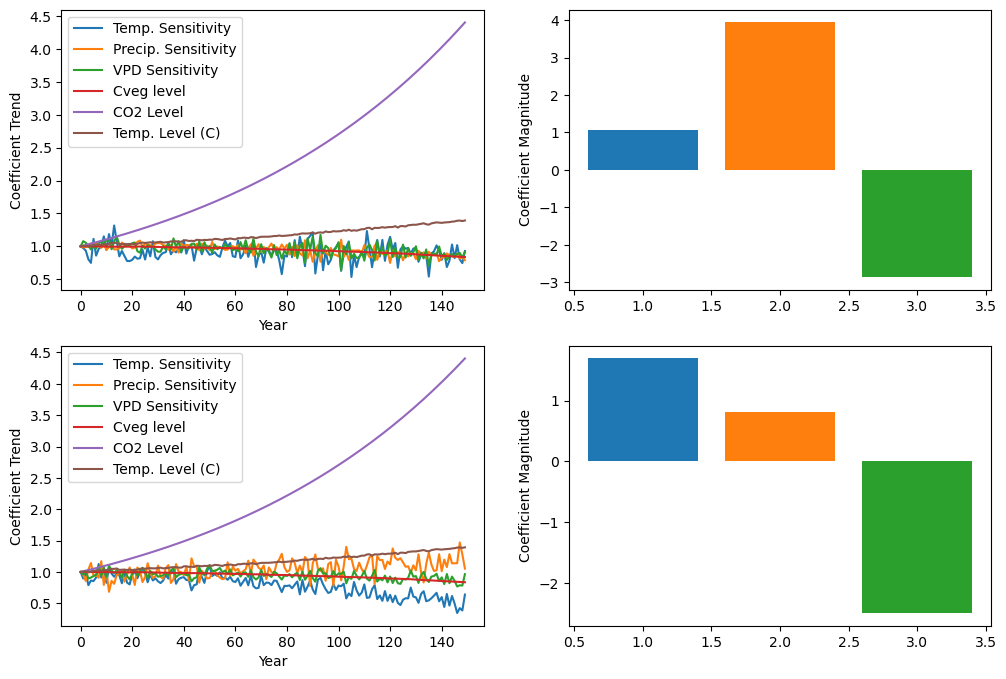

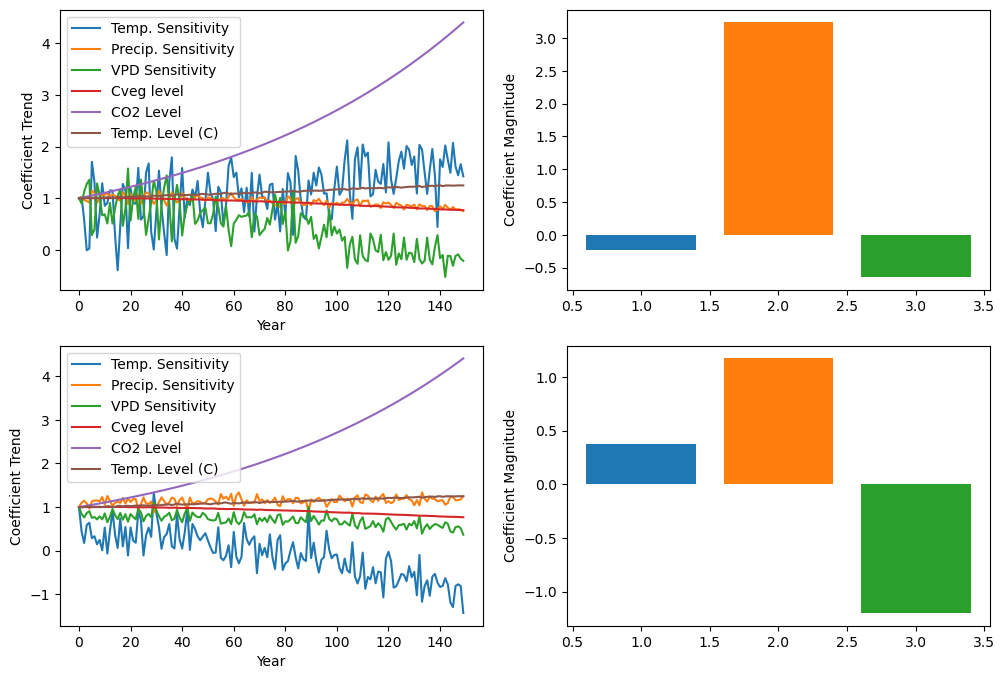

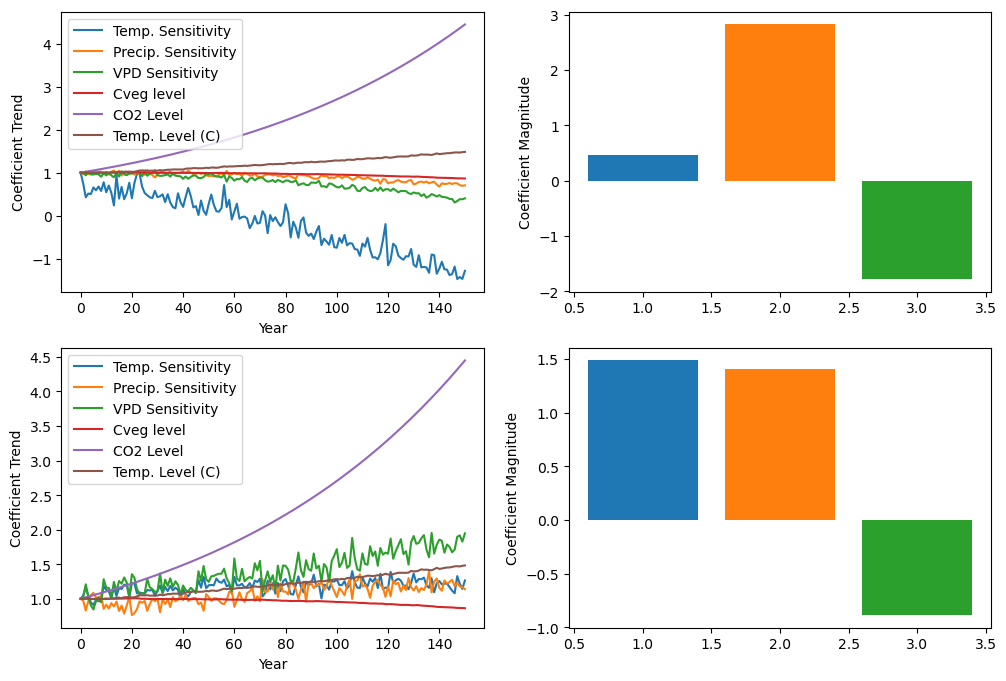

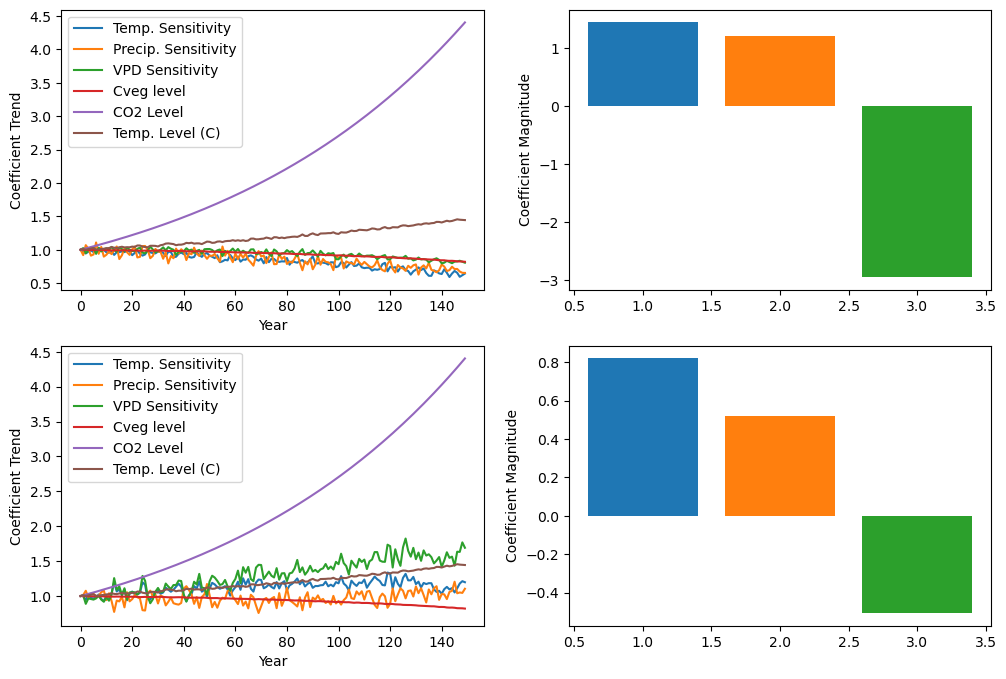

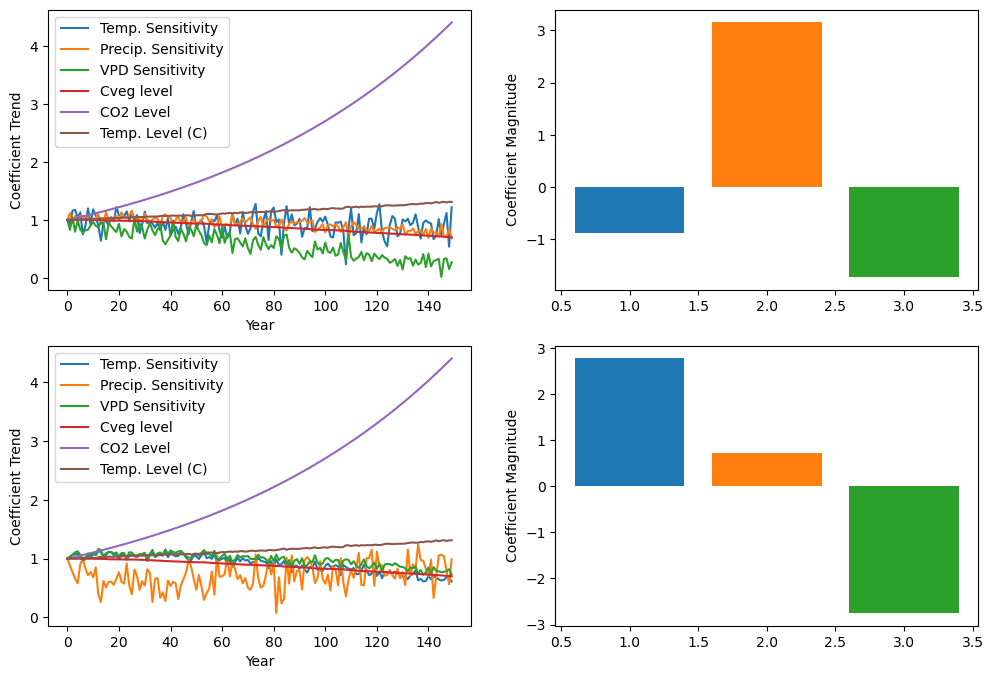

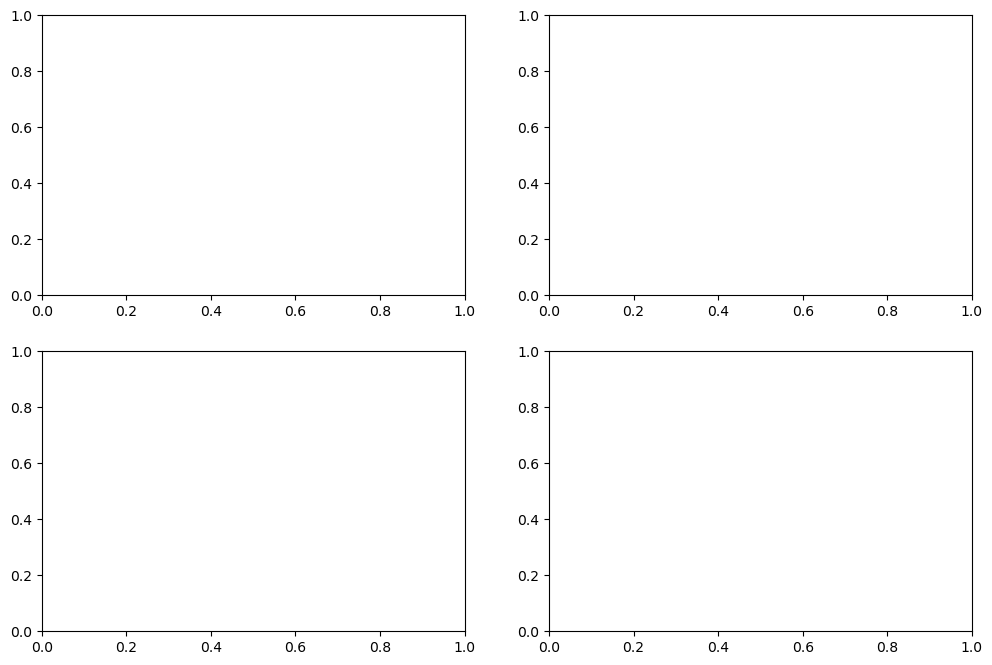

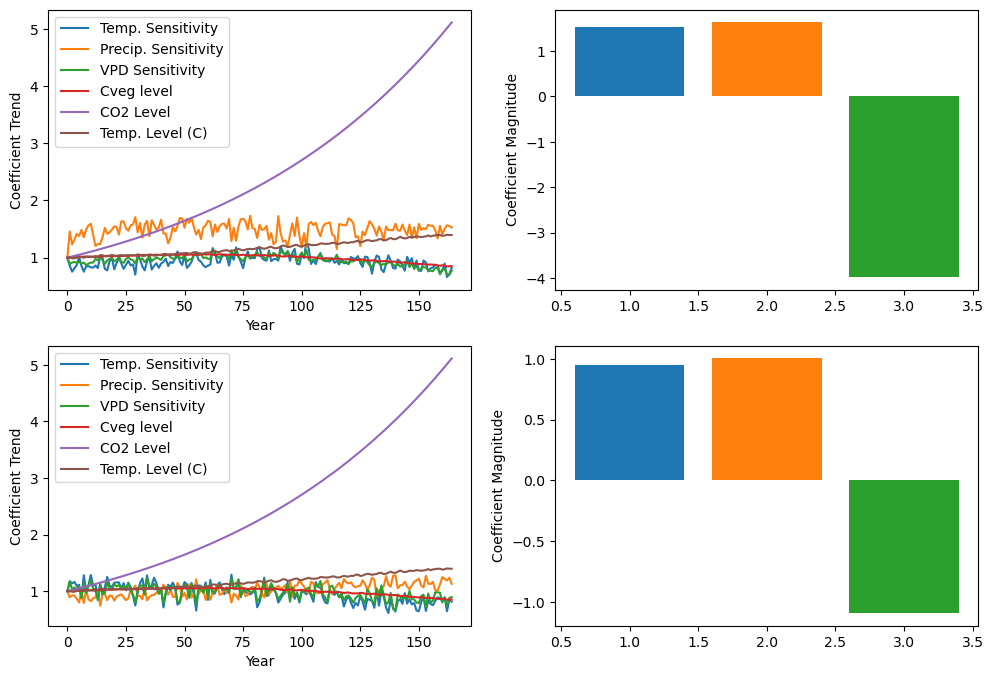

In [11]:

figmap = {}
actualfigmap = {}

exptype = "./1pctCO2-rad/"

for expname in list_experiments(exptype, "hurs"):
    (actualfigmap[expname], figmap[expname]) = plt.subplots(2,2, figsize=(12, 8))

def meanyear(arr):
    layout = arr.shape
    return arr.reshape((layout[0]//12, 12, layout[1], layout[2])).mean(axis=1)

def fastfit(x,y,mask):
    std0 = np.std(x[0,mask])
    std1 = np.std(x[1,mask])
    std2 = np.std(x[2,mask])

    
    x = x[:,mask]#.flatten()
    x = np.array(x).transpose()
    y = y[mask].flatten()

    # Fit and score model
    model = LinearRegression()
    model.fit(x, y)

    R2 = model.score(x, y)

    adjusted = [model.coef_[0] * std0, model.coef_[1] * std1, model.coef_[2] * std2]
    return {"x":model.coef_, "X":adjusted, "r2":R2}

for expname in list_experiments(exptype, "hurs"):
    if expname == "MPI-ESM1-2-LR":
        continue
    
    fullname = expname + " " + exptype.replace("/","").replace(".","")
    print(fullname)
    cveg_data = load(exptype, "cVeg", expname)
    cveg_year = meanyear(cveg_data)
    cveg_data = 0 # These 0 assignments are necessary to force deallocations early instead of at end of scope
    
    pr_data = load(exptype, "pr", expname)
    pr_year = meanyear(pr_data)
    pr_data = 0
    
    ts_data = load(exptype, "ts", expname)
    ts_year = meanyear(ts_data)
    
    hurs_data = load(exptype, "hurs", expname)
    vpd_data = vpd(ts_data, hurs_data)

    hurs_data = 0
    ts_data = 0
    
    vpd_year = meanyear(vpd_data)

    vpd_data = 0

    tropic_paths = []
    tropic_r2 = []
    extra_paths = []
    extra_r2 = []
    
    for i in range(cveg_year.shape[0]):
        tropics = np.full([cveg_year[i,:].shape[0],cveg_year[i,:].shape[1]], False)
        tropics[cveg_year[i,:].shape[0]//3:2*cveg_year[i,:].shape[0]//3,:] = True

        mask1 = (cveg_year[i,:] > 0) & tropics
        mask2 = (cveg_year[i,:] > 0) & ~tropics
        
        tropic_results = fastfit(np.array([ts_year[i,:], pr_year[i,:], vpd_year[i,:]]), cveg_year[i,:], mask1)        
        tropic_paths.append(tropic_results["X"])
        tropic_r2.append(tropic_results["r2"])
        extra_results = fastfit(np.array([ts_year[i,:], pr_year[i,:], vpd_year[i,:]]), cveg_year[i,:], mask2)
        extra_paths.append(extra_results["X"])
        extra_r2.append(extra_results["r2"])

    weights = cuts(cveg_year.shape[1],cveg_year.shape[2])

    CO2 = 1
    for i in range(cveg_year.shape[0]):
        values = np.nan_to_num(cveg_year[i,:])
        avg_cveg = np.sum(values * weights)
        values_ts = np.nan_to_num(ts_year[i,:])
        avg_ts = np.sum(values_ts * weights)
        tropic_paths[i].append(avg_cveg)
        extra_paths[i].append(avg_cveg)
        tropic_paths[i].append(CO2)
        extra_paths[i].append(CO2)
        tropic_paths[i].append(avg_ts - 273.15)
        extra_paths[i].append(avg_ts - 273.15)
        CO2 *= 1.01

    cveg_year = 0
    ts_year = 0
    pr_year = 0
    hurs_year = 0
    vpd_year = 0

    tropic_paths = np.array(tropic_paths)
    extra_paths = np.array(extra_paths)

    filetropic = "sensitivity_" + fullname.lower().replace(" ","_").replace("-","_") + "_tropic.png"
    fileextra = "sensitivity_" + fullname.lower().replace(" ","_").replace("-","_") + "_extra.png"

    multi = figmap.get(expname)

    c = 0
    l = ["Temp. Sensitivity", "Precip. Sensitivity", "VPD Sensitivity", "Cveg level", "CO2 Level", "Temp. Level (C)"]
    d = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

    multi[0][1].bar([1,2,3],tropic_paths[0,:-3],color=d)
    multi[1][1].bar([1,2,3],extra_paths[0,:-3],color=d)

    
    #multi[0][0].set_prop_cycle(cycle)
    multi[0][0].plot(tropic_paths / tropic_paths[0,:])
    #multi[0][0].plot(tropic_paths[:,0:3] / tropic_paths[0,0:3],color=d[0:3])
    #multi[0][0].plot(tropic_paths[:,3:] / tropic_paths[0,3:], linestyle='--', color=d[3:])
    multi[0][0].legend(l)
    multi[0][0].set_xlabel("Year")
    multi[0][0].set_ylabel("Coefficient Trend")
    multi[0][1].set_ylabel("Coefficient Magnitude")
    multi[1][0].plot(extra_paths / extra_paths[0,:])
    #multi[1][0].plot(extra_paths[:,0:3] / extra_paths[0, 0:3],color=d[0:3])
    #multi[1][0].plot(extra_paths[:,3:] / extra_paths[0, 3:], linestyle='--',color=d[3:])
    multi[1][0].legend(l)
    multi[1][0].set_xlabel("Year")
    multi[1][0].set_ylabel("Coefficient Trend")
    multi[1][1].set_ylabel("Coefficient Magnitude")


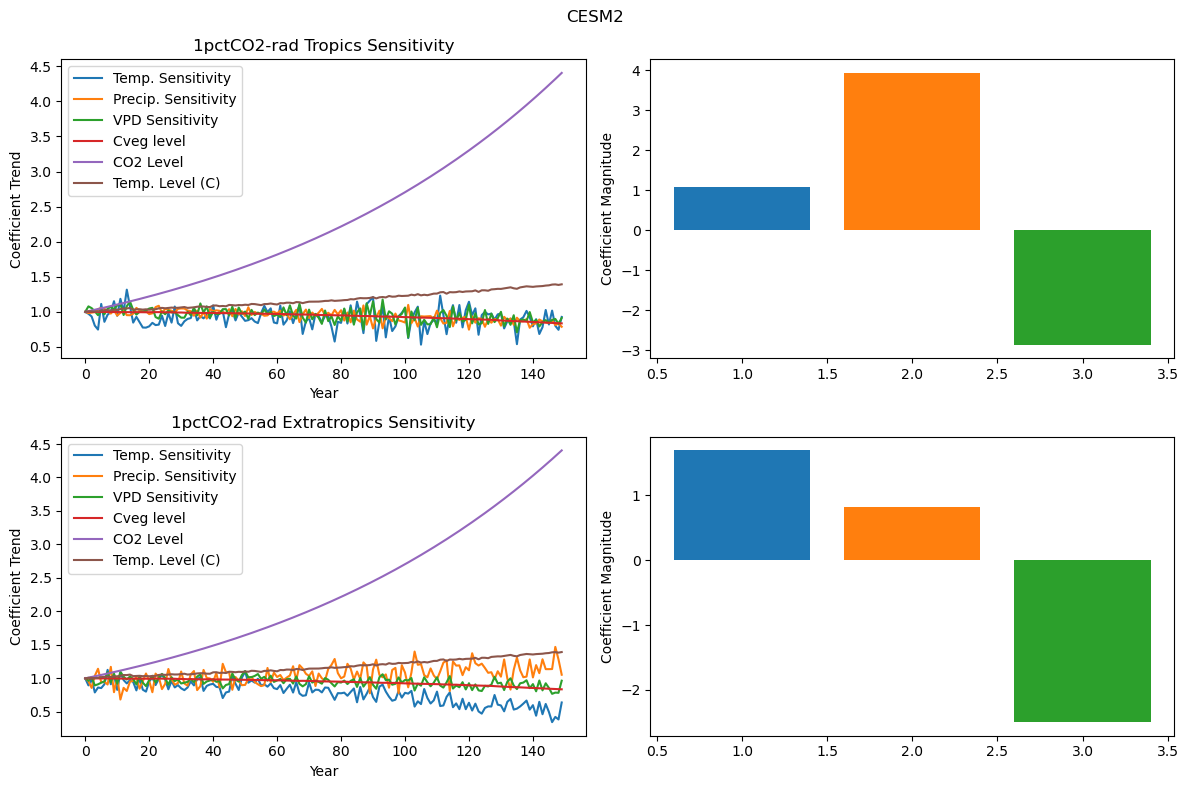

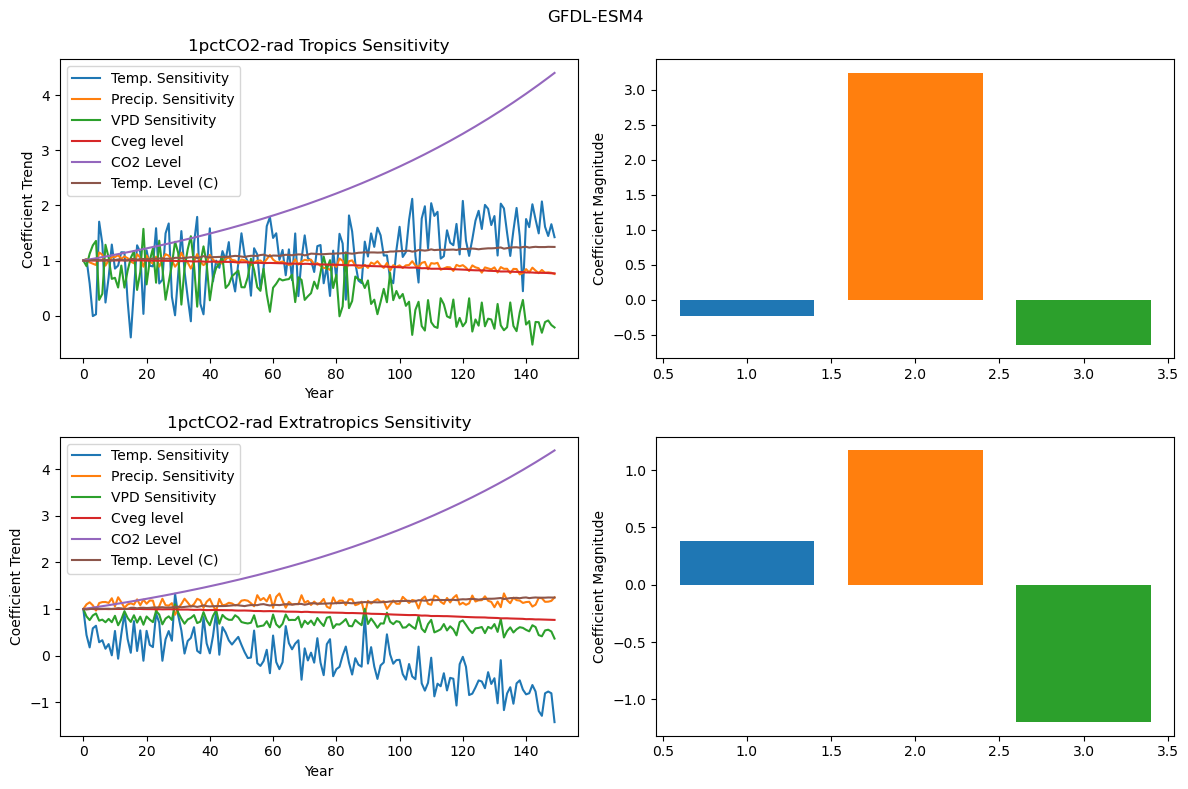

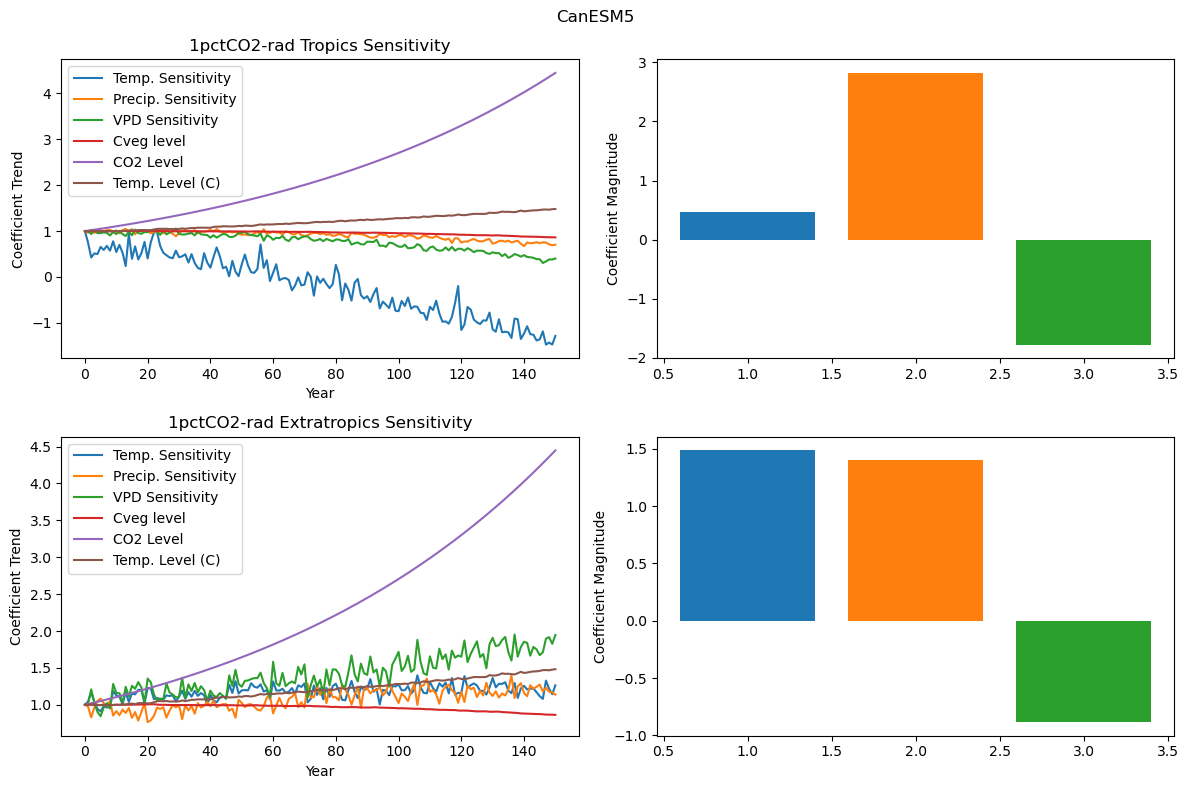

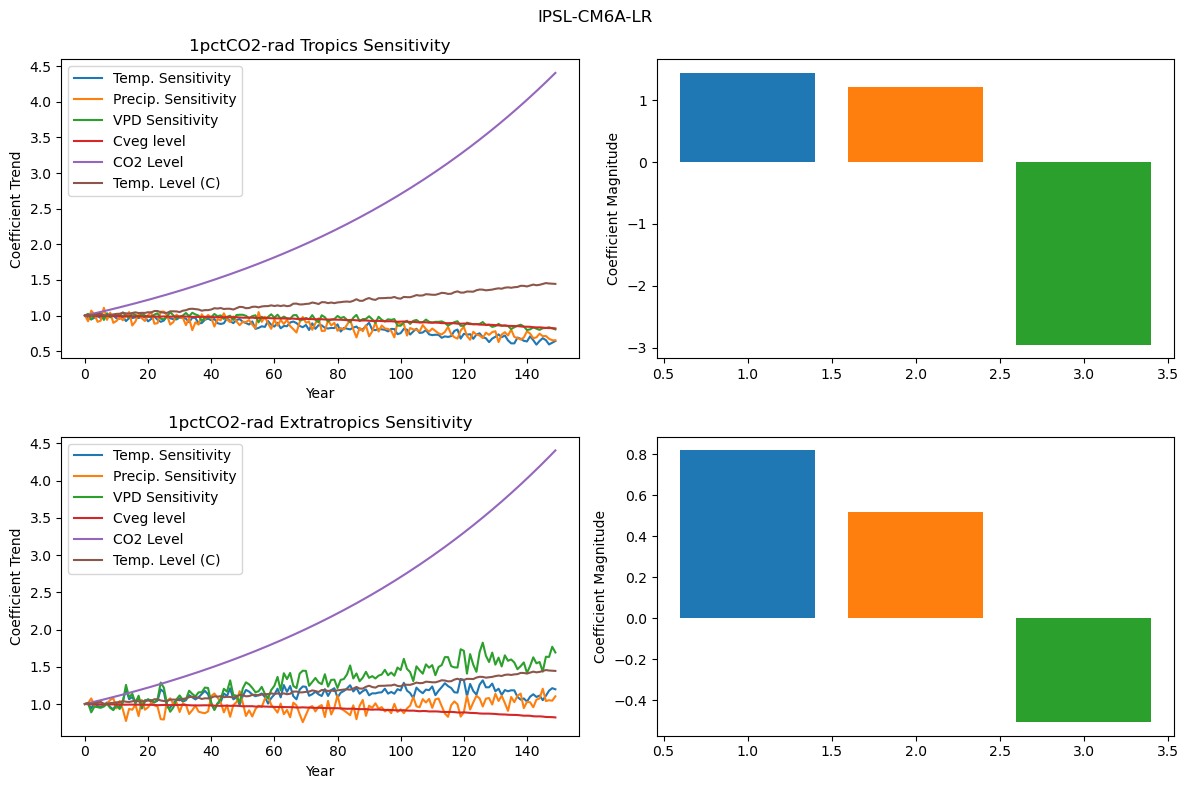

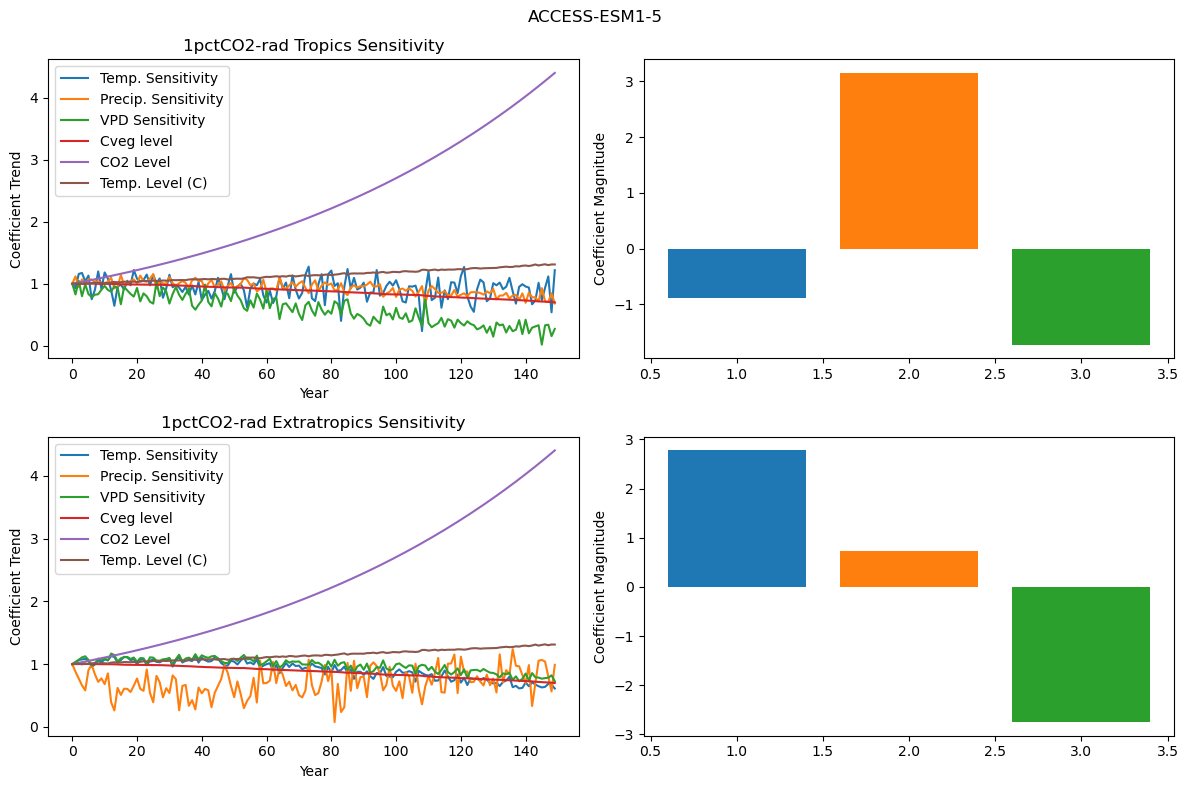

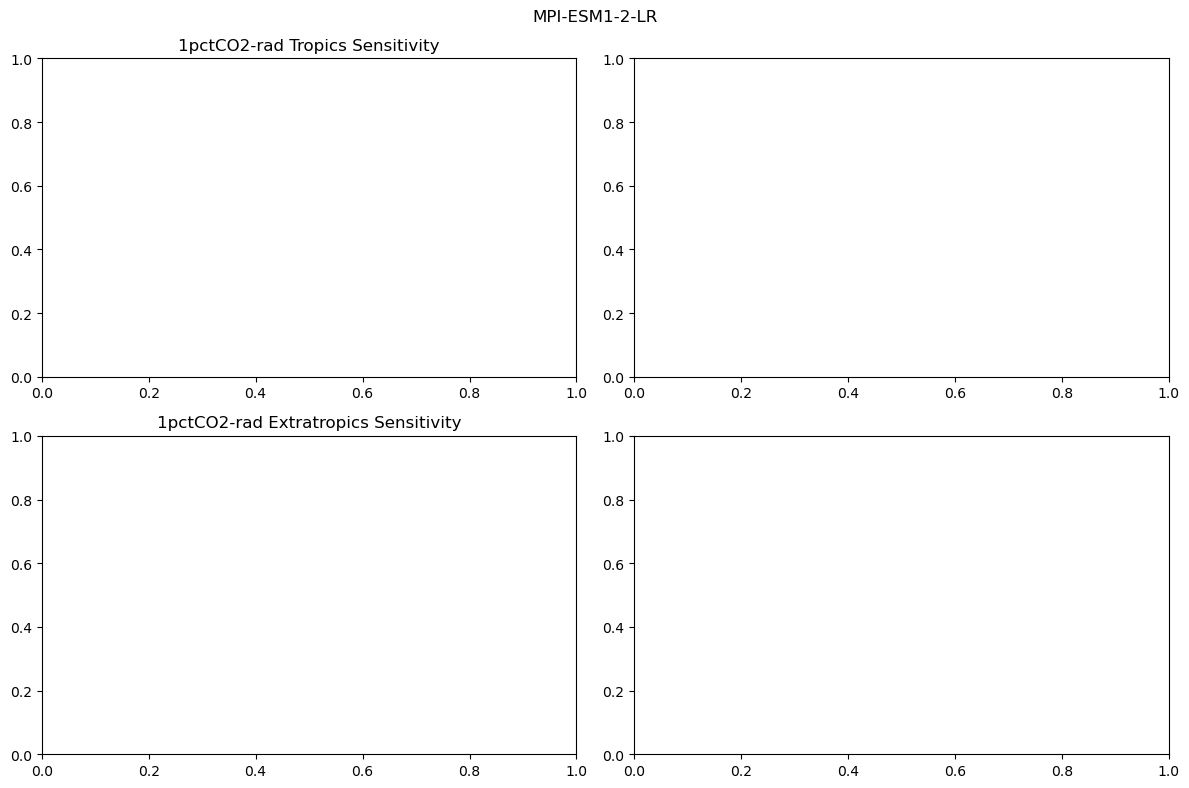

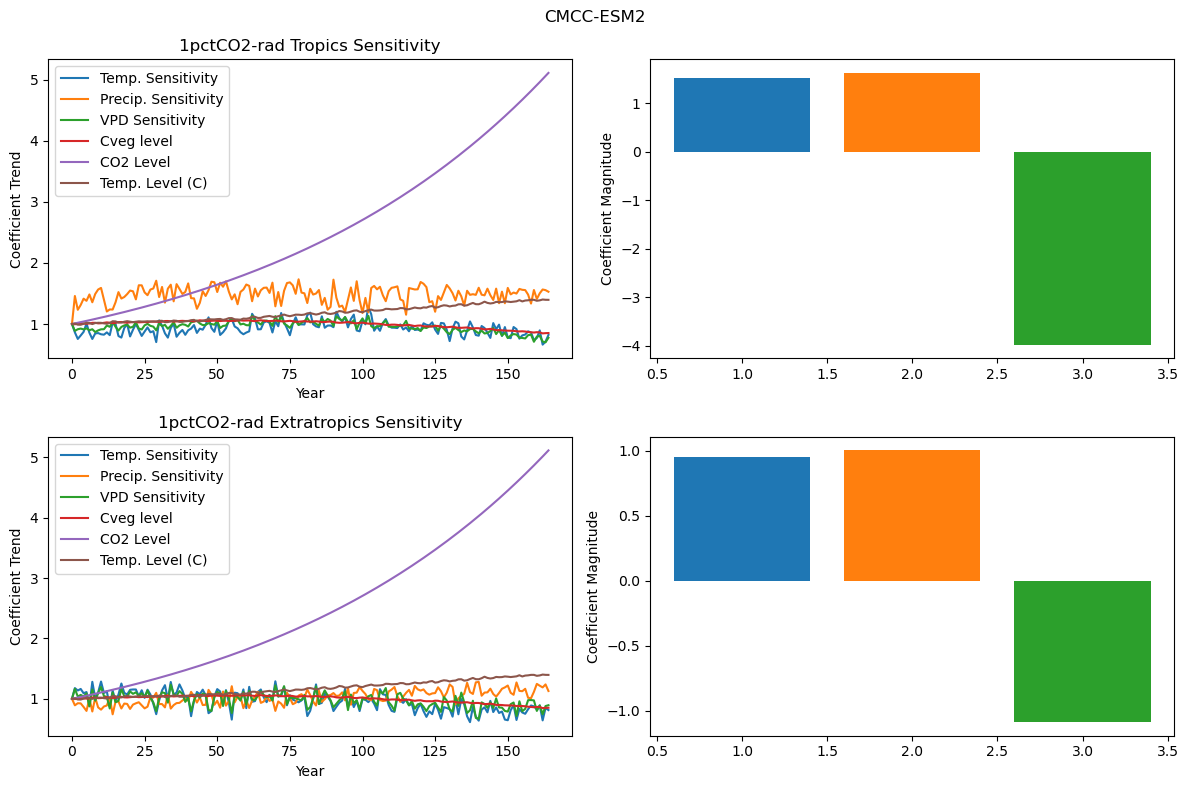

In [12]:
for expname in list_experiments("1pctCO2-rad", "hurs"):
    figmap[expname][0, 0].set_title("1pctCO2-rad Tropics Sensitivity")
    figmap[expname][1, 0].set_title("1pctCO2-rad Extratropics Sensitivity")
    #figmap[expname][0, 1].set_title("piSST-4xCO2-rad Tropics Sensitivity")
    #figmap[expname][1, 1].set_title("piSST-4xCO2-rad Extratropics Sensitivity")
    fig = actualfigmap[expname]
    fig.suptitle(expname)
    fig.tight_layout()
    plt.figure(fig)
    plt.show()
    fig.savefig("combined_sensitivity_" + expname + ".png")

In [13]:
from sklearn.metrics import mean_squared_error
def fasteval(x,y,mask):
    xs = [None] * len(x)
    for i in range(len(x)):
        xs[i] = x[i].flatten() 
    
    mask = mask.flatten()
    
    model_inputs = (np.array(xs)[:, mask]).transpose()
    model_output = y.flatten()[mask]

    # Fit and score model
    model = LinearRegression()
    model.fit(model_inputs, model_output)

    pred = model.predict(model_inputs)
    
    mse = mean_squared_error(model_output, pred)
    n = np.sum(mask)
    return mse * n




exptype = "./1pctCO2-rad/"

tropic_sse = 0
tropic_n = 0
extra_sse = 0
extra_n = 0
k = 0

for expname in list_experiments(exptype, "hurs"):
    print(expname)
    cveg_data = load(exptype, "cVeg", expname)
    pr_data = load(exptype, "pr", expname)
    ts_data = load(exptype, "ts", expname)
    hurs_data = load(exptype, "hurs", expname)
    
    ts = avg20(ts_data[start_y:end_y,:,:])
    pr = avg20(pr_data[start_y:end_y,:,:])
    hurs = avg20(hurs_data[start_y:end_y,:,:])
    cveg = avg20(cveg_data[start_y:end_y,:,:])
    vvpd = vpd(ts, hurs)

    
    tropics = np.full([cveg.shape[0],cveg.shape[1]], False)
    tropics[cveg.shape[0]//3:2*cveg.shape[0]//3,:] = True

    tropic_mask = (cveg > 0) & tropics
    extra_mask = (cveg > 0) & ~tropics

    params = [ts, pr, ts*pr, np.sqrt(pr)]
    k = len(params)
    tropic_sse += fasteval(params, cveg, tropic_mask)
    tropic_n += np.sum(tropic_mask)
    extra_sse += fasteval(params, cveg, extra_mask)
    extra_n += np.sum(extra_mask)

print("Tropic AIC", (2 * k) + (tropic_n * np.log(tropic_sse/tropic_n)))
print("Extras AIC", (2 * k) + (extra_n * np.log(extra_sse/extra_n)))

CESM2
GFDL-ESM4
CanESM5
IPSL-CM6A-LR
ACCESS-ESM1-5
MPI-ESM1-2-LR
CMCC-ESM2
Tropic AIC 66495.09324615353
Extras AIC 75196.78161778355


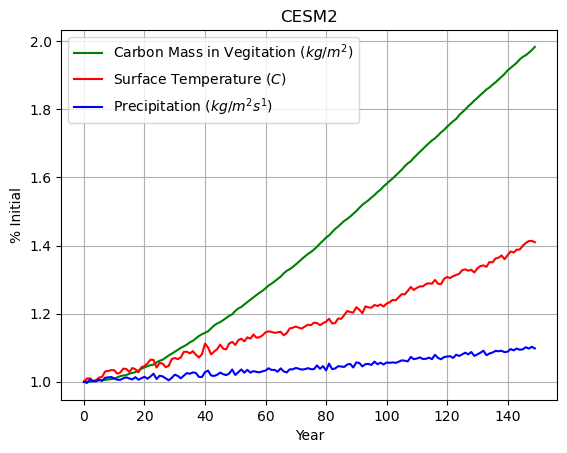

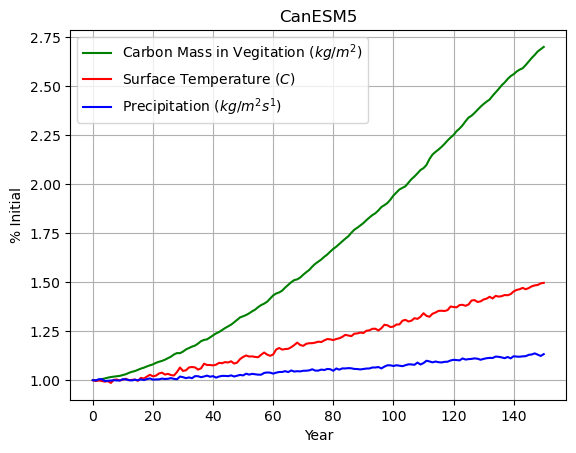

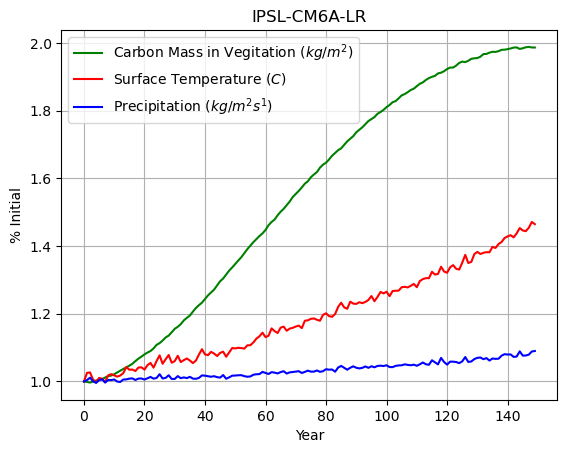

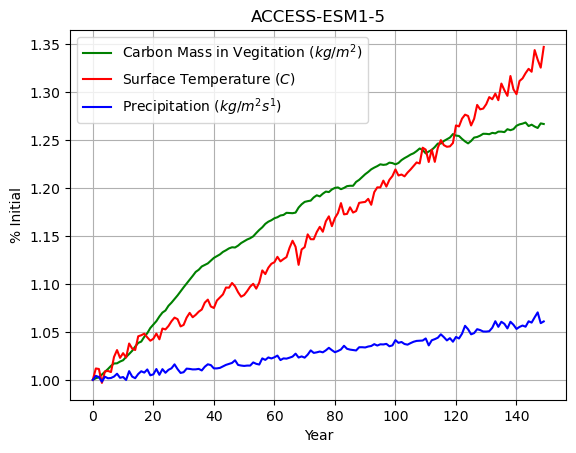

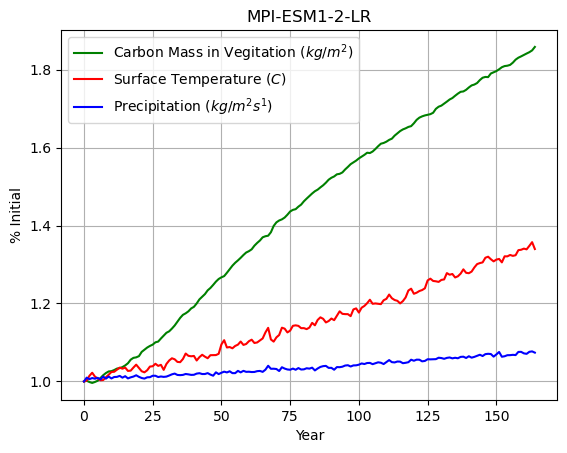

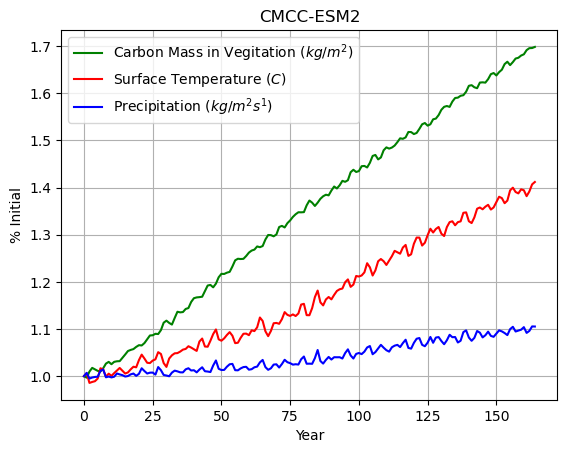

In [14]:
a_exp = "./1pctCO2/"
a_models = list(list_experiments(a_exp, "hurs"))
a_varnames = ["cVeg", "ts", "pr"]
a_col = ["g", "r", "b"]
a_legend = ["Carbon Mass in Vegitation $(kg/m^{2})$", "Surface Temperature $(C)$", "Precipitation $(kg/m^{2}s^{1})$"]


for a_model in a_models:
    plt.figure()
    for i in range(len(a_varnames)):
        
        values = load(a_exp,a_varnames[i], a_model)
        weights = cuts(values.shape[1],values.shape[2])
    
        values = np.nan_to_num(values)
        if a_varnames[i] == "ts":
            values = values - 273.15
        monthly = np.sum(values * weights, axis=(1,2))
        yearly = np.mean(monthly.reshape(-1, 12), axis=1)
        
        plt.plot(yearly/yearly[0], color=a_col[i])

    plt.legend(a_legend)
    plt.ylabel("% Initial")
    plt.xlabel("Year")
    plt.title(a_model)
    plt.grid()
    plt.show()

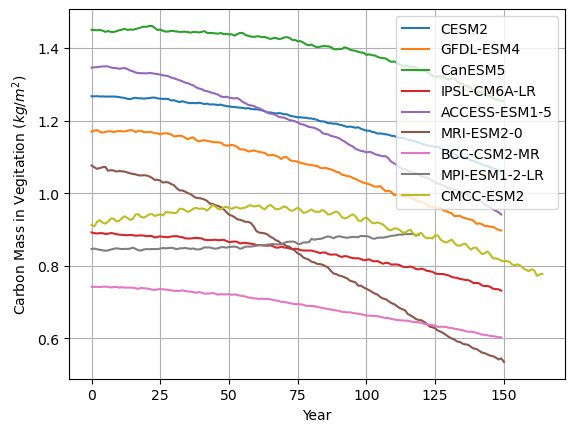

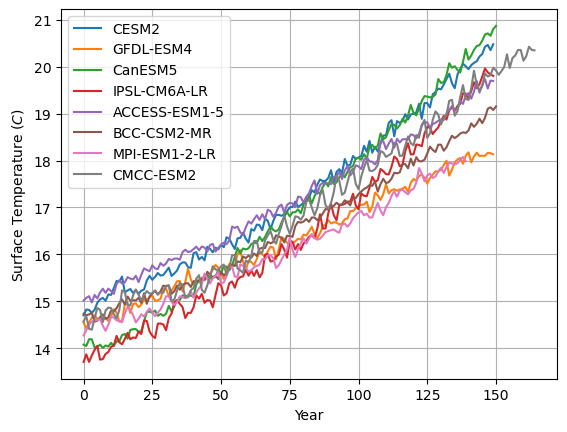

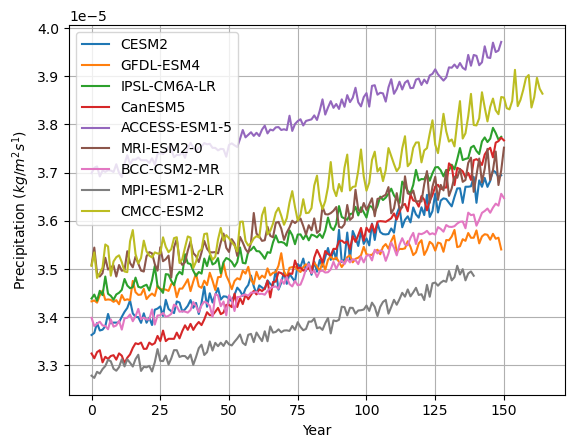

In [15]:
b_exp = "./1pctCO2-rad/"

b_varnames = ["cVeg", "ts", "pr"]
b_ylabels = ["Carbon Mass in Vegitation $(kg/m^{2})$", "Surface Temperature $(C)$", "Precipitation $(kg/m^{2}s^{1})$"]

for i in range(len(b_varnames)):
    plt.figure()
    b_varname = b_varnames[i]
    b_ylabel = b_ylabels[i]
    b_models = list(list_experiments(b_exp, b_varname))
    for b_model in b_models:
                
        values = load(b_exp, b_varname, b_model)
        weights = cuts(values.shape[1],values.shape[2])
        
        values = np.nan_to_num(values)
        if b_varname == "ts":
            values = values - 273.15
        monthly = np.sum(values * weights, axis=(1,2))
        yearly = np.mean(monthly.reshape(-1, 12), axis=1)
            
        plt.plot(yearly)
    
    plt.legend(b_models)
    plt.grid()
    plt.ylabel(b_ylabel)
    plt.xlabel("Year")
    plt.show()


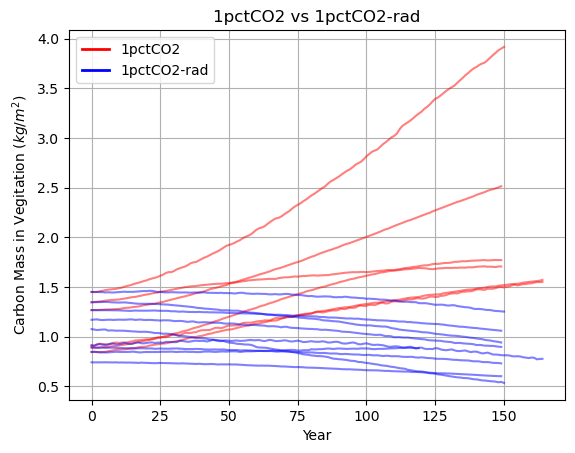

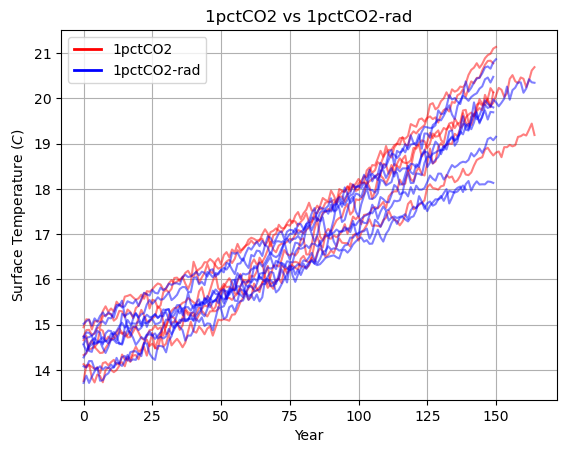

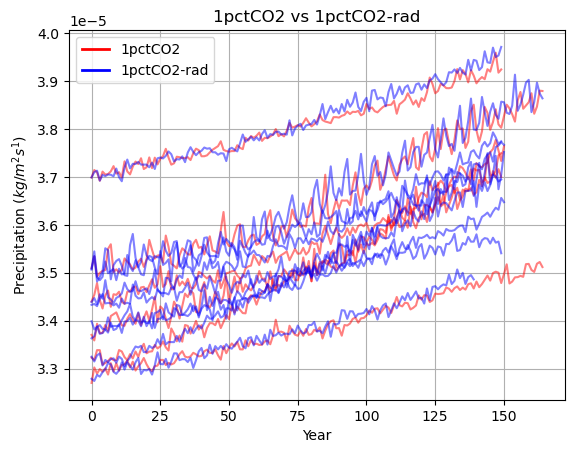

In [16]:
c1_exp = "./1pctCO2/"
c2_exp = "./1pctCO2-rad/"
c_varnames = ["cVeg", "ts", "pr"]
c_ylabels = ["Carbon Mass in Vegitation $(kg/m^{2})$", "Surface Temperature $(C)$", "Precipitation $(kg/m^{2}s^{1})$"]

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='r', lw=2, label='1pctCO2'), Line2D([0], [0], color='b', lw=2, label='1pctCO2-rad')]

for i in range(len(c_varnames)):
    c_varname = c_varnames[i]
    c_ylabel = c_ylabels[i]
    plt.figure()
    
    c1_models = list(list_experiments(c1_exp, c_varname))
    c2_models = list(list_experiments(c2_exp, c_varname))
    for c1_model in c1_models:
                
        values = load(c1_exp, c_varname, c1_model)
        if c_varname == "ts":
            values = values - 273.15
        weights = cuts(values.shape[1],values.shape[2])
        
        values = np.nan_to_num(values)
        monthly = np.sum(values * weights, axis=(1,2))
        yearly = np.mean(monthly.reshape(-1, 12), axis=1)
            
        plt.plot(yearly, color="red", alpha=0.5)
    
    for c2_model in c2_models:
                
        values = load(c2_exp, c_varname, c2_model)
        if c_varname == "ts":
            values = values - 273.15
        weights = cuts(values.shape[1],values.shape[2])
        
        values = np.nan_to_num(values)
        monthly = np.sum(values * weights, axis=(1,2))
        yearly = np.mean(monthly.reshape(-1, 12), axis=1)
            
        plt.plot(yearly, color="blue", alpha=0.5)
    
    plt.grid()
    plt.ylabel(c_ylabel)
    plt.xlabel("Year")
    plt.title("1pctCO2 vs 1pctCO2-rad")
    plt.legend(handles=legend_elements)
    plt.show()


# Quarter project

(25, 180, 288)


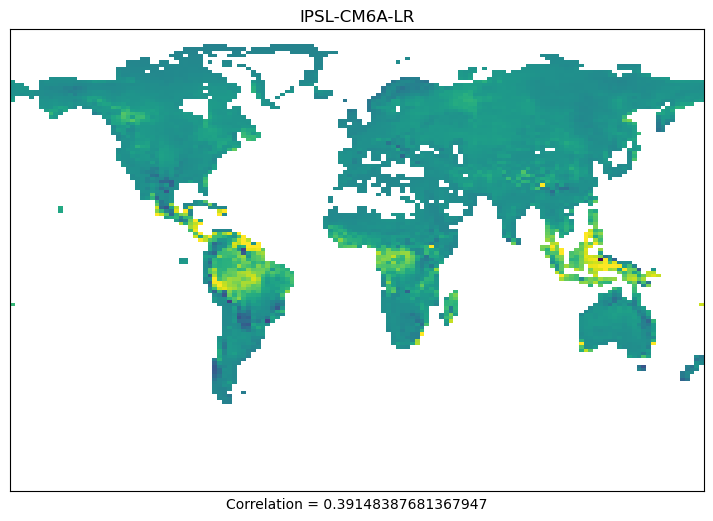

(25, 180, 288)


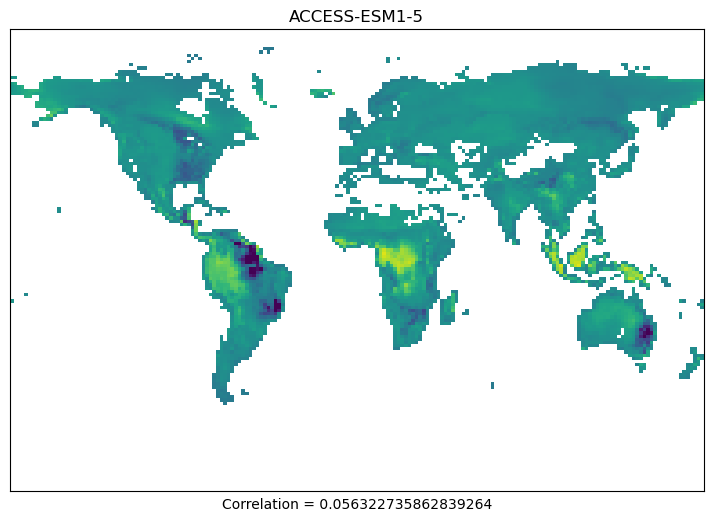

(25, 180, 288)


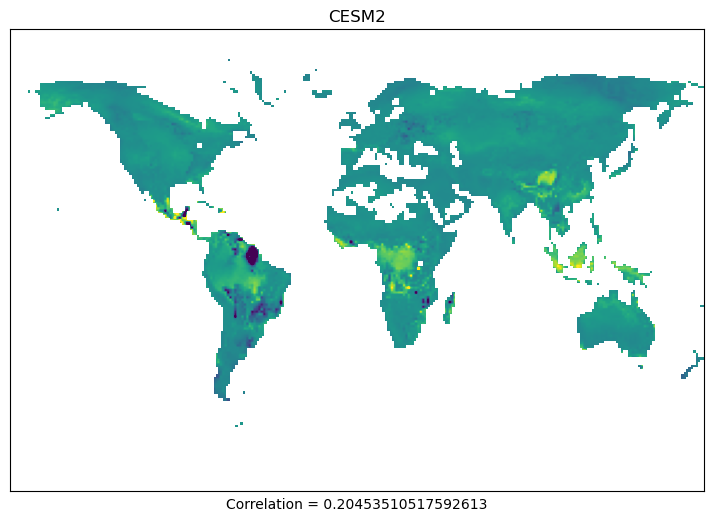

(25, 180, 288)


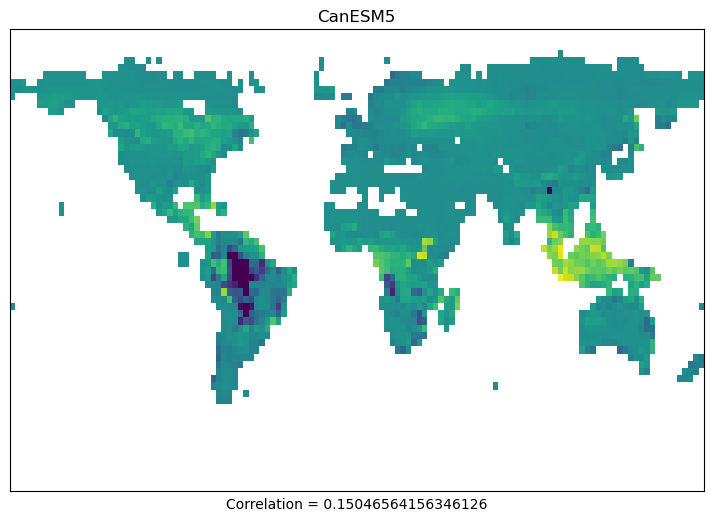

(25, 180, 288)


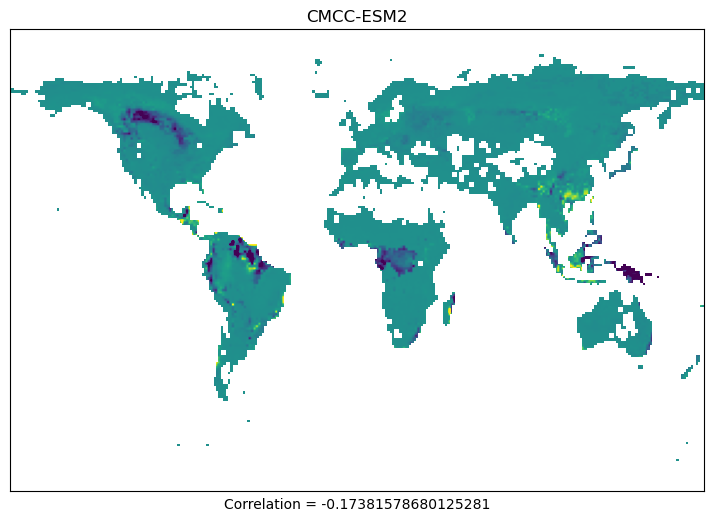

(25, 180, 288)


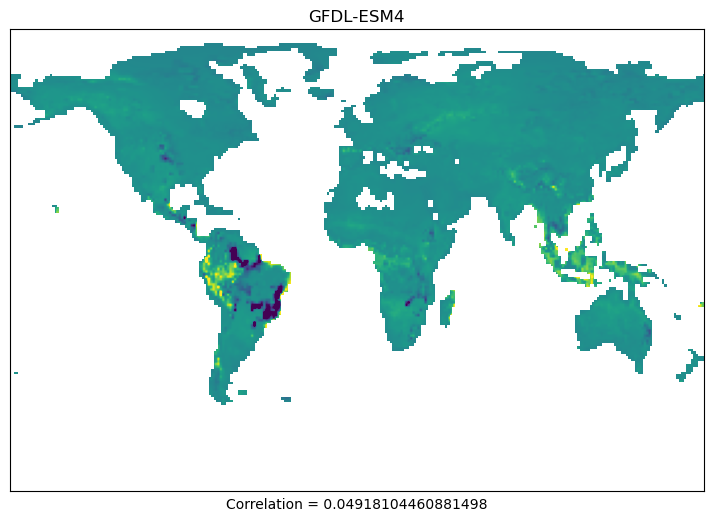

In [16]:
# Correlation plots
q_models = ['IPSL-CM6A-LR', 'ACCESS-ESM1-5', 'CESM2', 'CanESM5', 'CMCC-ESM2', 'GFDL-ESM4']

def yrload(a, b, c):
    values = load(a,b,c)
    weights = cuts(values.shape[1],values.shape[2])
    return np.mean((np.nan_to_num(values) * weights).reshape(-1, 12, values.shape[1], values.shape[2]), axis=1)

def manualcorrplot(x,y,mask):
    mean_x = np.mean(x.flatten()[mask])
    mean_y = np.mean(y.flatten()[mask])
    std_x = np.std(x.flatten()[mask])
    std_y = np.std(y.flatten()[mask])

    
    output = ((x - mean_x)/std_x) * ((y - mean_y)/std_y)
    mask = mask.reshape((output.shape[0], output.shape[1]))
    output[~mask] = np.nan
    return output
    

for q_model in q_models:
    plt.figure(figsize=(9, 6))
            
    #qts = yrload("./historical/", "ts", q_model)[0:25,]
    #qpr = yrload("./historical/", "pr", q_model)[0:25,]
    qvpd = vpd(yrload("./historical/", "ts", q_model)[0:25,], yrload ("./historical/", "hurs", q_model)[0:25,])

    print(qvpd.shape)
    
    qcveg = yrload("./1pctCO2-rad/", "cVeg", q_model)
    mask = (qcveg[0,] > 0).flatten()
    change = np.mean(qcveg[75:100,:,:] - qcveg[0:25,:,:], axis=0)
    
            
    #monthly = values * weights
    #print(monthly.shape)
    #yearly = np.mean(monthly.reshape(-1, 12, values.shape[1], values.shape[2]), axis=1)
    #print(yearly.shape)
    
    stddev = np.std(qvpd, axis=0)
    corr = np.corrcoef(stddev.flatten()[mask], change.flatten()[mask])[0][1]

    globe(manualcorrplot(stddev, change, mask)[::-1], vmin=-5,vmax=5, aspect=0.666*change.shape[1]/change.shape[0])
    #plt.colorbar(shrink = 0.67)
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
        
    plt.title(q_model)
    plt.xlabel("Correlation = " + str(corr))
    plt.savefig(q_model + "_corr_ts.png", bbox_inches='tight', transparent="True", pad_inches=0.1)
    plt.show()
    